In [2]:
# Imports

# import argparse
import pysam
import polars as pl

from functools import reduce
from pathlib import Path

%load_ext line_profiler

Main question: How well does the input bamfile align to all the reference genomes?
Metric of choice: Alignment Score (AS)
Data needed: sequence identifier, species aligned, bamfile
- for qc: mapq, NM

1 bam:species alignment -> csv: id,flag,as,mapq,nm
^ repeat the above per species
merge csv & into dataframe

perform qc with bitwise flag, mapq, nm

extract into final csv w/ given schema:
id: str
top_as_fp: filepath
top_as: int
second_as_fp: filepath
second_as: int

dealing with filtering:
if bam passes qc (flag 260 / mapq / NM) for some refseqs but not others, 
how should that factor into final output?

if bam passes mapq/NM for all refs, do we still want that data with
model?

note: bwa mem keeps all reads in bamfile whether they align or not
=> can expect set of unique reads to be equal across all bams from same fastq pair

until then: include everything

in the end i need: read, top alignment, 2nd best alignment
top && 2nd => best alignment, how much better it is than the rest


final pipeline:

input: directory of bamfiles (assumed: same fastqs, diff refs)
1. per bamfile: extract id, flag, mapq, nm, as -> pd.DataFrame (also dump into csv)
2. perform qc on dfs (still some concerns to sort out)
3. dump output into csv (id:str,top_as_fp:str,top_as:int,second_as_fp:str,second_as:int)
   (potential to append mapq/nm to schema)

port pandas -> polars afterwards (better memory scaling, parsing large bam)

In [ ]:
# Utility functions

def load_bamfile(bampath: str | Path) -> pl.DataFrame:
    """ 
    Extracts read ID (qname + _R1/2), mapq, NM, and AS values for a bamfile (only
    for primary/unmapped read entries) and dumps them in a polars DataFrame.
    """

    if not isinstance(bampath, Path):
        bampath = Path(str(bampath))
    species = bampath.stem
    
    with pysam.AlignmentFile(str(bampath), "rb") as bamfile:
        records = [
            (
                f"{read.query_name}_{'R1' if read.is_read1 else 'R2'}",  # qname + _R1/2, unique ID
                read.mapping_quality,                                    # mapq
                int(read.get_tag("NM")) if read.has_tag("NM") else -1,   # num mismatches, opt sam tag
                int(read.get_tag("AS")),                                 # align score, given by bwa mem, 0 if unmapped
            )
            for read in bamfile.fetch(until_eof=True)
            if not (read.is_secondary or read.is_supplementary)
        ]

    return pl.DataFrame(
        data=records,
        orient="row",
        schema={
            "unique_read_id": pl.String,
            f"{species}_mapq": pl.Int16,
            f"{species}_nm": pl.Int16,
            f"{species}_as": pl.Int16,
        }
    )


def load_bamfile_columnar(bampath: str | Path) -> pl.DataFrame:
    if not isinstance(bampath, Path):
        bampath = Path(str(bampath))
    species = bampath.stem

    
    with pysam.AlignmentFile(str(bampath), "rb") as bamfile:
        uid, mapq, num_mismatch, align_score = [], [], [], []

        for read in bamfile.fetch(until_eof=True):
            if not (read.is_secondary or read.is_supplementary):
                uid.append(f"{read.query_name}_{'R1' if read.is_read1 else 'R2'}")           # qname + _R1/2, unique ID
                mapq.append(read.mapping_quality)                                            # mapq
                num_mismatch.append(int(read.get_tag("NM")) if read.has_tag("NM") else -1)   # num mismatches, opt sam tag
                align_score.append(int(read.get_tag("AS")))                                  # align score, given by bwa mem, 0 if unmapped
    
    return pl.DataFrame(
        data=[uid, mapq, num_mismatch, align_score],
        schema={
            "unique_read_id": pl.String,
            f"{species}_mapq": pl.Int16,
            f"{species}_nm": pl.Int16,
            f"{species}_as": pl.Int16,
        }
    )
        
def get_top_2(
    row: tuple,
    as_species: list[tuple[str, int]],
    nm_indices: dict[str, int],
    mapq_indices: dict[str, int]
) -> tuple:
    sample = row[0]

    # Build list of (species, score) using precomputed AS positions
    as_scores = [(species, row[idx]) for species, idx in as_species]

    if len(as_scores) < 2:
        return (sample,) + (None,) * 6  # Pad with Nones if fewer than 2 scores

    # Sort by alignment score and take top 2
    top2 = sorted(as_scores, key=lambda x: x[1], reverse=True)[:2]
    (top_fp, top_as), (second_fp, second_as) = top2

    # Lookup NM / MAPQ values using precomputed column indices
    top_nm    = row[nm_indices[top_fp]]
    second_nm = row[nm_indices[second_fp]]
    top_mapq    = row[mapq_indices[top_fp]]
    second_mapq = row[mapq_indices[top_fp]]

    return sample, top_as, second_as, top_nm, second_nm, top_mapq, second_mapq, top_fp, second_fp

In [4]:
bampath = Path("/gpfs/commons/home/apandit/gghome/lions/align-out-mut0/bamfiles")
%lprun -f load_bamfile_columnar load_bamfile_columnar(bampath/"bobcat.bam")

Timer unit: 1e-09 s

Total time: 29.8005 s
File: /scratch/ipykernel_1379930/849262706.py
Function: load_bamfile_columnar at line 37

Line #      Hits         Time  Per Hit   % Time  Line Contents
    37                                           def load_bamfile_columnar(bampath: str | Path) -> pl.DataFrame:
    38         1       2960.0   2960.0      0.0      if not isinstance(bampath, Path):
    39                                                   bampath = Path(str(bampath))
    40         1      18462.0  18462.0      0.0      species = bampath.stem
    41                                           
    42                                               
    43         2   46929647.0 2.35e+07      0.2      with pysam.AlignmentFile(str(bampath), "rb") as bamfile:
    44         1       3628.0   3628.0      0.0          uid, mapq, num_mismatch, align_score = [], [], [], []
    45                                           
    46   2006132 9196092874.0   4584.0     30.9          for read i


```
Timer unit: 1e-09 s

Total time: 33.2319 s
File: /scratch/ipykernel_1317095/2095975900.py
Function: load_bamfile at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     3                                           def load_bamfile(bampath: str | Path) -> pl.DataFrame:
     4                                               """ 
     5                                               Extracts read ID (qname + _R1/2), mapq, NM, and AS values for a bamfile (only
     6                                               for primary/unmapped read entries) and dumps them in a polars DataFrame.
     7                                               """
     8                                           
     9         1       3221.0   3221.0      0.0      if not isinstance(bampath, Path):
    10                                                   bampath = Path(str(bampath))
    11         1      16781.0  16781.0      0.0      species = bampath.stem
    12                                               
    13         2    2063414.0 1.03e+06      0.0      with pysam.AlignmentFile(str(bampath), "rb") as bamfile:
    14         2     3.02e+10 1.51e+10     90.9          records = [
    15                                                       (
    16                                                           f"{read.query_name}_{'R1' if read.is_read1 else 'R2'}",  # qname + _R1/2, unique ID
    17                                                           read.mapping_quality,                                    # mapq
    18                                                           int(read.get_tag("NM")) if read.has_tag("NM") else -1,   # num mismatches, opt sam tag
    19                                                           int(read.get_tag("AS")),                                 # align score, given by bwa mem, 0 if unmapped
    20                                                       )
    21         1      25265.0  25265.0      0.0              for read in bamfile.fetch(until_eof=True)
    22                                                       if not (read.is_secondary or read.is_supplementary)
    23                                                   ]
    24                                           
    25         1       1280.0   1280.0      0.0      return (
    26         2 3027631752.0 1.51e+09      9.1          pl.DataFrame(
    27         1       3848.0   3848.0      0.0              data=records,
    28         1       8470.0   8470.0      0.0              orient="row",
    29         1       6539.0   6539.0      0.0              schema={
    30         1       9469.0   9469.0      0.0                  "unique_read_id": pl.String,
    31         1      12887.0  12887.0      0.0                  f"{species}_mapq": pl.Int16,
    32         1       4237.0   4237.0      0.0                  f"{species}_nm": pl.Int16,
    33         1       1798.0   1798.0      0.0                  f"{species}_as": pl.Int16,
    34                                                       }
    35                                                   )
    36                                               )
    ```

In [5]:
# Parse raw bamfiles & extract unique reads
# expensive cell, only run when needed or face wait times of doom (~30sec)

bampath = Path("/gpfs/commons/home/apandit/gghome/lions/align-out-mut0/bamfiles")

species_list  = ("bobcat", "cat", "human", "lion")
species_paths = [bampath/f"{species_name}.bam" for species_name in species_list]


source_df = load_bamfile(species_paths[0])
print(f"{species_paths[0].name}  \t{source_df.estimated_size(unit='mb'):.2f} Mb")

for species_path in species_paths[1:]:
    species_df = load_bamfile(species_path)
    print(f"{species_path.name}  \t{species_df.estimated_size(unit='mb'):.2f} Mb")
    source_df = source_df.join(other=species_df, on="unique_read_id")
    del species_df  # every million reads adds ~51Mb ram used, wise to clean up large objects
source_df

bobcat.bam  	105.71 Mb
cat.bam  	105.71 Mb
human.bam  	105.71 Mb
lion.bam  	105.71 Mb


unique_read_id,bobcat_mapq,bobcat_nm,bobcat_as,cat_mapq,cat_nm,cat_as,human_mapq,human_nm,human_as,lion_mapq,lion_nm,lion_as
str,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16
"""NC_028302.1_456_846_2:0:0_1:0:…",0,-1,0,0,6,29,0,-1,0,60,2,60
"""NC_028302.1_456_846_2:0:0_1:0:…",0,2,44,0,1,49,0,-1,0,60,1,68
"""NC_028302.1_575_917_2:0:0_1:0:…",9,4,53,0,5,48,0,-1,0,51,1,65
"""NC_028302.1_575_917_2:0:0_1:0:…",0,-1,0,0,5,25,0,-1,0,60,2,60
"""NC_028302.1_2389_2758_0:0:0_0:…",51,1,65,0,2,60,24,5,45,60,0,70
…,…,…,…,…,…,…,…,…,…,…,…,…
"""NW_024962249.1_73072_73421_2:0…",4,6,44,0,4,50,0,-1,0,0,0,70
"""NW_024962249.1_73296_73659_0:0…",0,5,45,3,5,43,0,-1,0,0,0,70
"""NW_024962249.1_73296_73659_0:0…",0,4,41,3,5,45,0,-1,0,0,4,54


In [8]:
qc_conditions = [
    ( 
        pl.col(species+"_mapq").is_between(20, 30, closed="left")   # mapq in [20, 30)
        & pl.col(species+"_nm").lt(6)                                 # and nm < 6
    ) 
    | 
    (                                                           # or
        pl.col(species+"_mapq").ge(30)                              # mapq 30+
        & pl.col(species+"_nm").lt(4)                                 # and nm < 4
    )
    for species in species_list
]
qc_conditions = reduce(lambda a, b: a | b, qc_conditions)

columns = source_df.columns
as_species  =  [(col[:-3], i) for i, col in enumerate(columns) if col.endswith("_as")]
nm_indices   = { col[:-3]: i  for i, col in enumerate(columns) if col.endswith("_nm")}
mapq_indices = { col[:-5]: i  for i, col in enumerate(columns) if col.endswith("_mapq")}

top_as, second_as = pl.col("top_as"), pl.col("second_as")
top_mapq, second_mapq = pl.col("top_mapq"), pl.col("second_mapq")
top_nm, second_nm = pl.col("top_nm"), pl.col("second_nm")

filtered_df = (
    source_df
    .filter(qc_conditions)
    .map_rows(lambda row: get_top_2(row, as_species, nm_indices, mapq_indices))
    .rename(mapping={
        "column_0": "unique_read_id",
        "column_1": "top_as",
        "column_2": "second_as",
        "column_3": "top_nm",
        "column_4": "second_nm",
        "column_5": "top_mapq",
        "column_6": "second_mapq",
        "column_7": "top_species",
        "column_8": "second_species"
    })
    .filter(
        (
            ( top_mapq.is_between(20, 29) & top_nm.lt(6) )
            | ( top_mapq.ge(30) & top_nm.lt(4) )
        )
        &
        (
            ( second_mapq.is_between(20, 29) & second_nm.lt(6) )
            | ( second_mapq.ge(30) & second_nm.lt(4) )
        )
    )
    .filter(top_as.ne(second_as))
)

In [19]:
# %pip install altair==5.4.0

pandas_df = (
    filtered_df
    .sort(by="second_as", descending=True, maintain_order=True)
    .sort(by="top_as",    descending=True,  maintain_order=True)
    .to_pandas()
)

pandas_df

,unique_read_id,top_as,second_as,top_nm,second_nm,top_mapq,second_mapq,top_species,second_species
0,NC_056679.1_17711_18151_0:0:0_0:0:0_8709_R1,70,69,0,1,60,60,lion,bobcat
1,NC_056679.1_1660934_1661293_0:0:0_0:0:0_18ef6_R2,70,69,0,1,60,60,lion,cat
2,NC_056679.1_2036769_2037020_0:0:0_1:0:0_15bb_R1,70,69,0,1,60,60,lion,bobcat
3,NC_056679.1_3287426_3287852_0:0:0_0:0:0_159e5_R1,70,69,0,1,40,40,lion,bobcat
4,NC_056679.1_3374816_3375223_0:0:0_0:0:0_5912_R2,70,69,0,1,40,40,lion,bobcat
...,...,...,...,...,...,...,...,...,...
870636,NC_056679.1_96048315_96048588_4:0:0_2:0:0_1899...,37,30,4,3,20,20,cat,lion
870637,NC_056691.1_3134561_3134929_3:0:0_8:0:0_53fc_R2,36,33,2,1,60,60,lion,bobcat
870638,NC_056682.1_123640751_123641122_7:0:0_1:0:0_14...,35,24,3,1,60,60,lion,bobcat
870639,NC_056684.1_6901876_6902178_0:0:0_8:0:0_e041_R1,35,21,3,1,44,44,lion,cat


<Axes: xlabel='second_as', ylabel='top_as'>

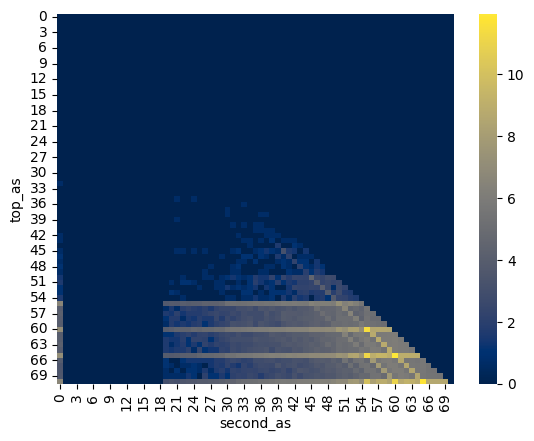

In [27]:
# %pip install seaborn
import seaborn as sns
import numpy as np
# sns.heatmap(data=pandas_df[["top_as", "second_as"]])

import pandas as pd

heatmap_df = pd.crosstab(pandas_df['top_as'], pandas_df['second_as'])

# Fill missing values with 0 to get full 71x71
heatmap_df = heatmap_df.reindex(index=range(71), columns=range(71), fill_value=0)

sns.heatmap(data=np.log1p(heatmap_df), cmap="cividis")

In [ ]:
def filter_for_mapq_nm(species: str, inverse: bool = False) -> pl.Expr:
    return ( 
        pl.col(species+"_mapq").is_between(20, 30, closed="left")   # mapq in [20, 30)
      & pl.col(species+"_nm").lt(6)                                 # and nm < 6
    ) | (                                                           # or
        pl.col(species+"_mapq").ge(30)                              # mapq 30+
      & pl.col(species+"_nm").lt(4)                                 # and nm < 4
    )

In [ ]:



def test_get_top_2():
    columns = ["unique_read_id", "human_mapq", "human_nm", "human_as", "lion_mapq", "lion_nm", "lion_as"]
    as_species = [(col[:-3], i) for i, col in enumerate(columns) if col.endswith("_as")]
    nm_indices = {col[:-3]: i for i, col in enumerate(columns) if col.endswith("_nm")}
    mapq_indices = {col[:-3]: i for i, col in enumerate(columns) if col.endswith("_mapq")}

    rowtuple = ("sample1", 28, 3, 40, 60, 0, 70)

    expected_score  = ("sample1", 70, 40, 0, 3, "lion", "human")
    expected_sample = ("sample1", 70, 0, "lion", 40, 3, "human")
    actual_score  = get_top_2(rowtuple, as_species, nm_indices=nm_indices, sort_by="score")
    actual_sample = get_top_2(rowtuple, as_species=as_species, nm_indices=nm_indices, sort_by="sample")
    actual_default = get_top_2(rowtuple, as_species=as_species, nm_indices=nm_indices)

    assert expected_score == actual_score
    assert expected_sample == actual_sample
    assert expected_score == actual_default


test_get_top_2()

In [ ]:
source_df

NameError: name 'source_df' is not defined